# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_percolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 10, 10
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['conv_7b']
    PREPROCESSING = tf.keras.applications.inception_resnet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8253 - accuracy: 0.7273

947/947 [==============================] - 5641s 6s/step - loss: 0.8253 - accuracy: 0.7273 - val_loss: 8.6380 - val_accuracy: 0.2231
Epoch 2/200
947/947 [==============================] - ETA: 0s - loss: 0.6992 - accuracy: 0.7593

947/947 [==============================] - 5305s 6s/step - loss: 0.6992 - accuracy: 0.7593 - val_loss: 0.7080 - val_accuracy: 0.7588
Epoch 3/200
947/947 [==============================] - 4850s 5s/step - loss: 0.6538 - accuracy: 0.7743 - val_loss: 4.9148 - val_accuracy: 0.6008
Epoch 4/200
947/947 [==============================] - ETA: 0s - loss: 0.6225 - accuracy: 0.7836

947/947 [==============================] - 5214s 6s/step - loss: 0.6225 - accuracy: 0.7836 - val_loss: 0.6403 - val_accuracy: 0.7773
Epoch 5/200
947/947 [==============================] - 4816s 5s/step - loss: 0.5892 - accuracy: 0.7936 - val_loss: 1.3323 - val_accuracy: 0.6819
Epoch 6/200
947/947 [==============================] - 4823s 5s/step - loss: 0.5915 - accuracy: 0.7914 - val_loss: 0.6901 - val_accuracy: 0.7703
Epoch 7/200
947/947 [==============================] - ETA: 0s - loss: 0.5471 - accuracy: 0.8059

947/947 [==============================] - 5217s 6s/step - loss: 0.5471 - accuracy: 0.8059 - val_loss: 0.6039 - val_accuracy: 0.7942
Epoch 8/200
947/947 [==============================] - ETA: 0s - loss: 0.5286 - accuracy: 0.8124

947/947 [==============================] - 5232s 6s/step - loss: 0.5286 - accuracy: 0.8124 - val_loss: 0.5409 - val_accuracy: 0.8068
Epoch 9/200
947/947 [==============================] - 4931s 5s/step - loss: 0.5069 - accuracy: 0.8190 - val_loss: 0.5882 - val_accuracy: 0.8015
Epoch 10/200
947/947 [==============================] - 4852s 5s/step - loss: 0.4983 - accuracy: 0.8237 - val_loss: 0.5825 - val_accuracy: 0.7983
Epoch 11/200
947/947 [==============================] - ETA: 0s - loss: 0.4841 - accuracy: 0.8295

947/947 [==============================] - 5289s 6s/step - loss: 0.4841 - accuracy: 0.8295 - val_loss: 0.5259 - val_accuracy: 0.8157
Epoch 12/200
947/947 [==============================] - 4842s 5s/step - loss: 0.4650 - accuracy: 0.8353 - val_loss: 0.6030 - val_accuracy: 0.7843
Epoch 13/200
947/947 [==============================] - ETA: 0s - loss: 0.4585 - accuracy: 0.8372

947/947 [==============================] - 5263s 6s/step - loss: 0.4585 - accuracy: 0.8372 - val_loss: 0.5257 - val_accuracy: 0.8139
Epoch 14/200
947/947 [==============================] - 4838s 5s/step - loss: 0.4302 - accuracy: 0.8451 - val_loss: 0.5271 - val_accuracy: 0.8173
Epoch 15/200
947/947 [==============================] - 4818s 5s/step - loss: 0.4182 - accuracy: 0.8497 - val_loss: 0.6103 - val_accuracy: 0.8049
Epoch 16/200
947/947 [==============================] - 5136s 5s/step - loss: 0.4098 - accuracy: 0.8531 - val_loss: 0.5559 - val_accuracy: 0.8082
Epoch 17/200
947/947 [==============================] - ETA: 0s - loss: 0.3998 - accuracy: 0.8554

947/947 [==============================] - 5286s 6s/step - loss: 0.3998 - accuracy: 0.8554 - val_loss: 0.4909 - val_accuracy: 0.8317
Epoch 18/200
947/947 [==============================] - ETA: 0s - loss: 0.3847 - accuracy: 0.8632

947/947 [==============================] - 5353s 6s/step - loss: 0.3847 - accuracy: 0.8632 - val_loss: 0.4754 - val_accuracy: 0.8334
Epoch 19/200
947/947 [==============================] - 4846s 5s/step - loss: 0.3713 - accuracy: 0.8660 - val_loss: 0.4959 - val_accuracy: 0.8305
Epoch 20/200
947/947 [==============================] - 5011s 5s/step - loss: 0.3605 - accuracy: 0.8677 - val_loss: 0.5334 - val_accuracy: 0.8197
Epoch 21/200
947/947 [==============================] - 4842s 5s/step - loss: 0.3648 - accuracy: 0.8693 - val_loss: 0.5157 - val_accuracy: 0.8266
Epoch 22/200
947/947 [==============================] - 4843s 5s/step - loss: 0.3406 - accuracy: 0.8776 - val_loss: 0.5554 - val_accuracy: 0.8123
Epoch 23/200
947/947 [==============================] - 4827s 5s/step - loss: 0.3317 - accuracy: 0.8789 - val_loss: 0.5188 - val_accuracy: 0.8299
Epoch 24/200
947/947 [==============================] - 4843s 5s/step - loss: 0.3317 - accuracy: 0.8822 - val_loss: 0.4836 - val_accuracy

947/947 [==============================] - 5270s 6s/step - loss: 0.3105 - accuracy: 0.8870 - val_loss: 0.4558 - val_accuracy: 0.8453
Epoch 26/200
947/947 [==============================] - 4866s 5s/step - loss: 0.2923 - accuracy: 0.8934 - val_loss: 0.4669 - val_accuracy: 0.8459
Epoch 27/200
947/947 [==============================] - 5087s 5s/step - loss: 0.2866 - accuracy: 0.8967 - val_loss: 0.4762 - val_accuracy: 0.8443
Epoch 28/200
947/947 [==============================] - 4831s 5s/step - loss: 0.2732 - accuracy: 0.9002 - val_loss: 0.4575 - val_accuracy: 0.8431
Epoch 29/200
947/947 [==============================] - ETA: 0s - loss: 0.2633 - accuracy: 0.9053

947/947 [==============================] - 5280s 6s/step - loss: 0.2633 - accuracy: 0.9053 - val_loss: 0.4467 - val_accuracy: 0.8486
Epoch 30/200
947/947 [==============================] - 5188s 5s/step - loss: 0.2597 - accuracy: 0.9039 - val_loss: 0.4831 - val_accuracy: 0.8440
Epoch 31/200
947/947 [==============================] - 4860s 5s/step - loss: 0.2401 - accuracy: 0.9105 - val_loss: 0.4798 - val_accuracy: 0.8448
Epoch 32/200
947/947 [==============================] - 4866s 5s/step - loss: 0.2410 - accuracy: 0.9103 - val_loss: 0.4645 - val_accuracy: 0.8525
Epoch 33/200
947/947 [==============================] - 4856s 5s/step - loss: 0.2258 - accuracy: 0.9166 - val_loss: 0.4850 - val_accuracy: 0.8456
Epoch 34/200
947/947 [==============================] - 4845s 5s/step - loss: 0.2197 - accuracy: 0.9192 - val_loss: 0.6316 - val_accuracy: 0.8226
Epoch 35/200
947/947 [==============================] - 4863s 5s/step - loss: 0.2102 - accuracy: 0.9239 - val_loss: 0.4778 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 491s 3s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9634737926095525,
 'basal cell carcinoma': 0.9843210269376195,
 'dermatofibroma': 0.9812982049006894,
 'melanoma': 0.9359435486626735,
 'nevus': 0.9665770999099802,
 'pigmented benign keratosis': 0.9858374531298512,
 'seborrheic keratosis': 0.9660147413428792,
 'solar lentigo': 0.9655950980819212,
 'squamous cell carcinoma': 0.9689060987415296,
 'vascular lesion': 0.9859402277828582}

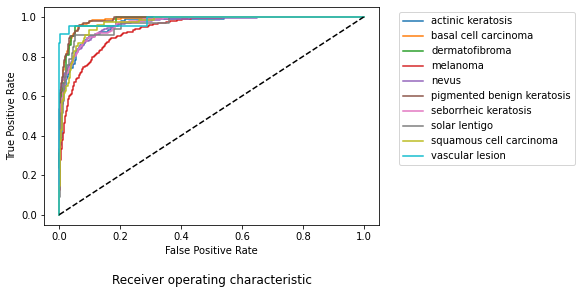

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

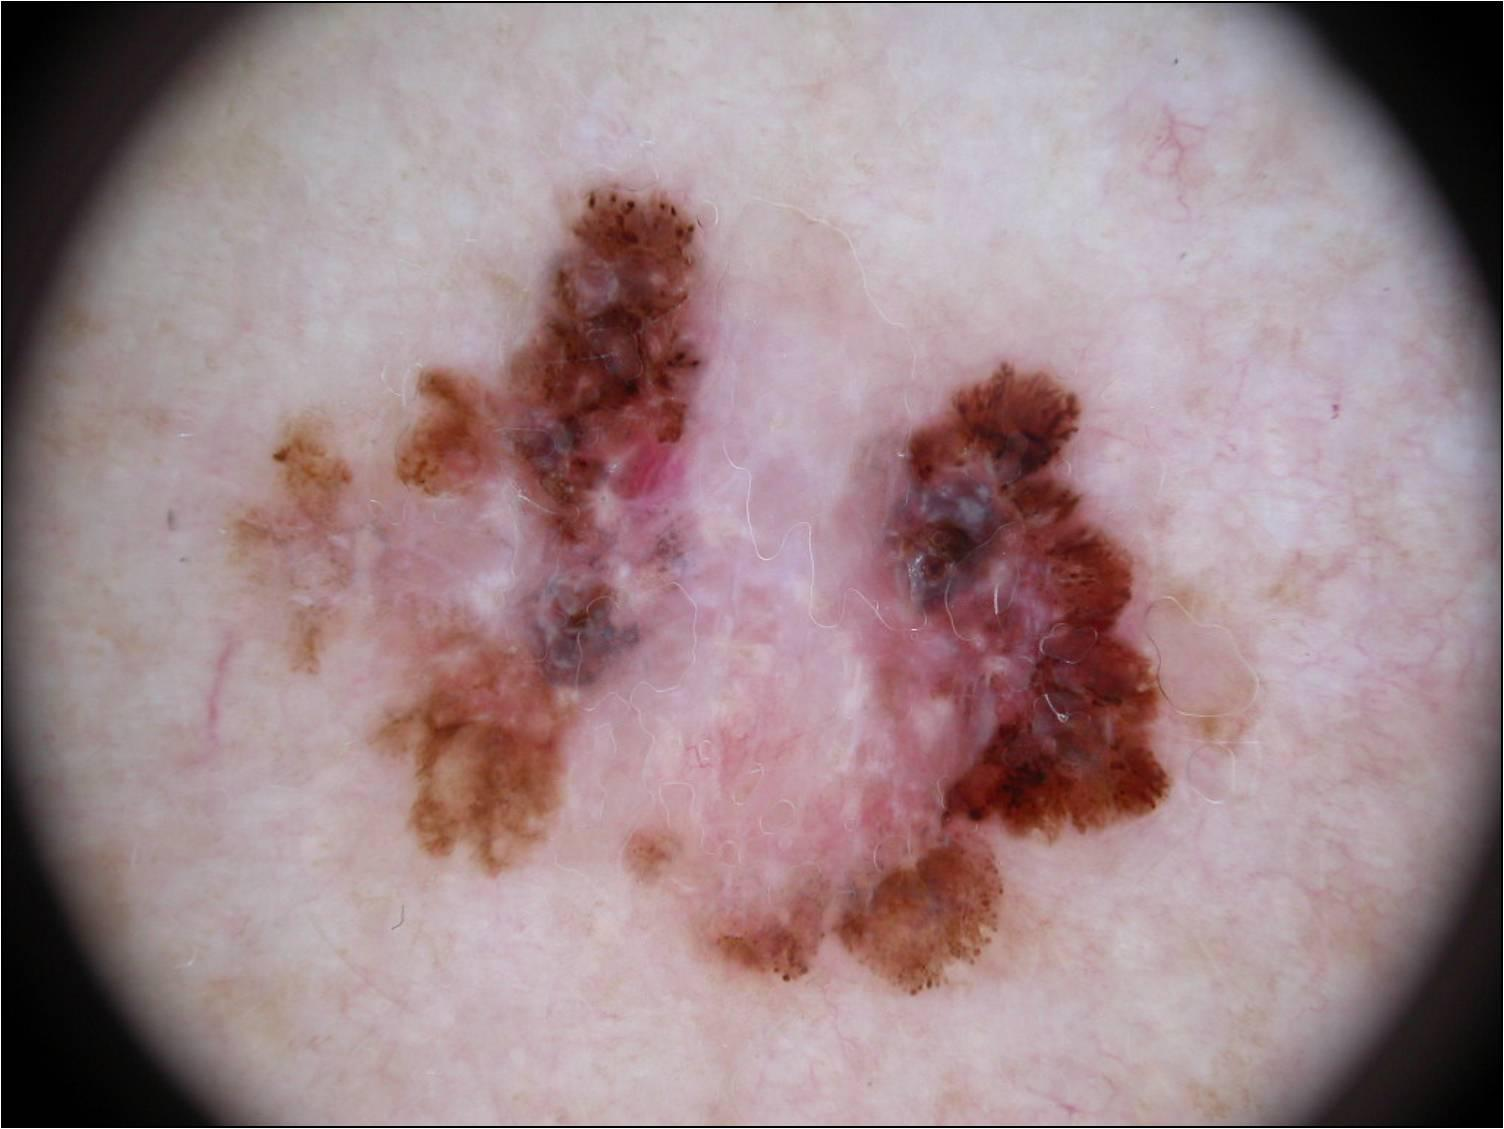

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, RETRAINABLE_LAYERS[-1])

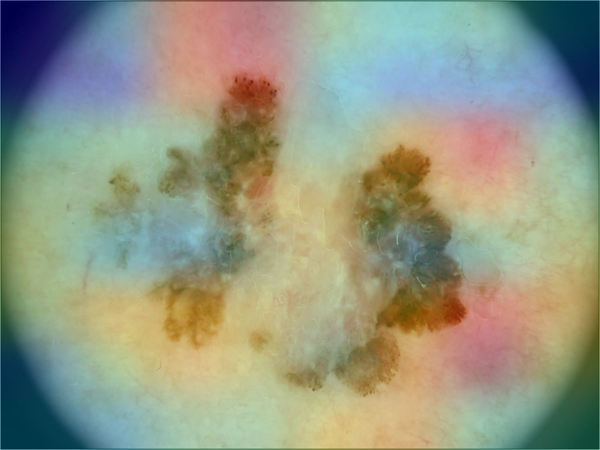

In [23]:
display_gradcam(melanoma_im_path, heatmap)